In [26]:
import numpy as np
import cv2
import os
from PIL import Image, ImageOps
import random
import matplotlib.pyplot as plt

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [28]:
def rotate_image(image, angle):
    height, width, _ = image.shape
    center = (width // 2, height // 2)
    degrees = random.normalvariate(0, angle)
    # Create the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, degrees, 1.0)
    # Perform the rotation
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image


def load_images_and_labels(base_path, angle=15):
    categories = ['paper', 'rock', 'scissors']

    images = []
    labels = []

    for category in categories:
        folder_path = os.path.join(base_path, category)
        for file_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                # Resizing to a shape appropriate for mediapipe model
                img = cv2.resize(img, (224, 224))
                # Rotate image by a random angle to add variety to the dataset
                rotated_img = rotate_image(img, angle)
                images.append(rotated_img)
                labels.append(category)

                # Add the flipped image to accound for left handed as well
                flipped_img = cv2.flip(img, 1)
                rotated_flipped_img = rotate_image(flipped_img, angle)
                images.append(rotated_flipped_img)
                labels.append(category)  # Append the same label for the flipped image

    return images, labels

In [29]:
X_train, y_train = load_images_and_labels('dataset/Rock-Paper-Scissors/train')
X_validation, y_validation = load_images_and_labels('dataset/Rock-Paper-Scissors/validation')
X_test, y_test = load_images_and_labels('dataset/Rock-Paper-Scissors/test')


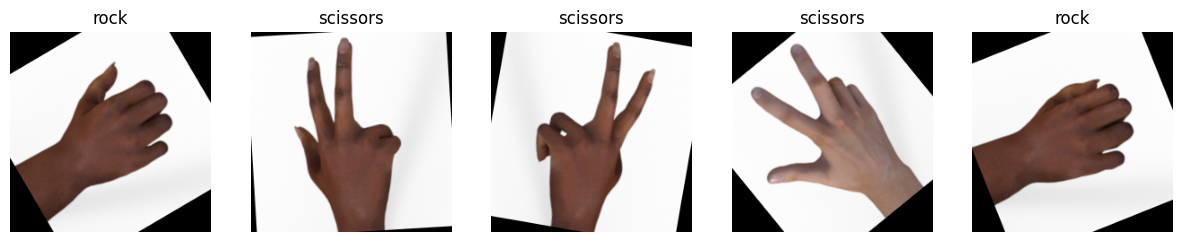

In [30]:
random_indices = random.sample(range(len(X_train)), 5)

# Set up the plot
fig, axes = plt.subplots(1, 5, figsize=(15, 10))

for ax, idx in zip(axes, random_indices):
    # Show image at the random index
    ax.imshow(cv2.cvtColor(X_train[idx], cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB
    ax.set_title(y_train[idx])
    ax.axis('off')  # Hide axes

plt.show()

In [36]:
# STEP 1: Import the necessary modules.


# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
# image = mp.Image.create_from_file("image.jpg")
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=X_test[1])

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

print(detection_result)
# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

HandLandmarkerResult(handedness=[], hand_landmarks=[], hand_world_landmarks=[])


AttributeError: 'HandLandmarkerResult' object has no attribute 'draw_landmarks'

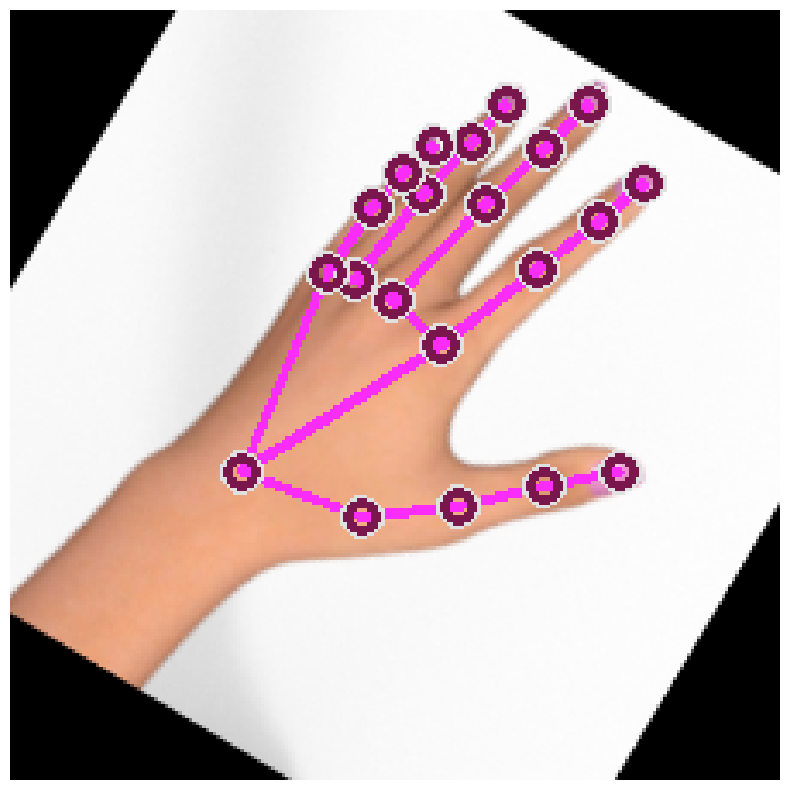

In [44]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Initialize MediaPipe Hand Landmarker.
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Options for the detector.
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5
)

# Function to draw landmarks on image
def draw_landmarks_on_image(image, results):
    annotated_image = image.copy()
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                annotated_image, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),
            )
    return annotated_image

# Load your image
# Assuming X_test[1] is a numpy array in BGR format
input_image = X_test[5]
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Process the image with MediaPipe
results = hands.process(input_image)

# Draw the landmarks on the image
annotated_image = draw_landmarks_on_image(input_image, results)

# Use Matplotlib to display the image
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis('off')  # Hide axes
plt.show()

# Release resources
hands.close()
